In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=5, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
        self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
#         self.CTXs = np.array([[0,1], [1,0]])
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0

## Model 1: LA, BLA, CeA with mixed excitation/inhibition
1. model 1 should reproduce behavioral data
    - conditioned freezing
    - extinction-induced reduction of freezing
2. model 1 should reproduce activity data from pyramidal neurons
    - LA neurons become CS-responsive after conditioning
    - LA neurons maintain CS-responsiveness after extinction
    - BLA fear neurons become CS-responsive after conditioning and lose CS-responsiveness after extinction
    - BLA extinction neurons become CS-responsive after extinction
    - BLA persistant neurons become CS-responsive after conditioning and maintain their activity after extinction

In [3]:
seed = 0
nNeurons = 200
dim_CS = 3
dim_CTX = 10
inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, seed=seed)

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01
intercepts_pos = nengo.dists.Uniform(0, 1)
encoders_pos = nengo.dists.Choice([[1]])
encoders_ctx = nengo.dists.Choice([[1, 0], [0, 1], [-1, 0], [0, -1]])

with net:
    # inputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=dim_CTX)
    # external ensembles
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX)
    # amygdala ensembles
    LA = nengo.Ensemble(2*nNeurons, 2, radius=2)  # [CS, US]
    CeA = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)  # [freeze (combined fear response)]
    error_CS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    error_noCS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(CTX, external_CTX, synapse=None)
    # learned connections
    conditioning = nengo.Connection(external_CS, LA[0], function=lambda x: 0, learning_rule_type=nengo.PES(1e-4))
    aversion = nengo.Connection(external_US, LA[1])
    # error connections
    nengo.Connection(LA, error_CS, function=lambda x: x[1]-x[0])  # US - (CS response)
    nengo.Connection(error_CS, conditioning.learning_rule, transform=-1)
    nengo.Connection(LA, error_noCS, function=lambda x: x[0])  # (CS response)
    nengo.Connection(external_CS, error_noCS, function=lambda x: -np.sum(np.square(x)))  # any CS present
    nengo.Connection(error_noCS, conditioning.learning_rule, transform=2)
    # output connections
    nengo.Connection(LA[0], CeA)  # CS response added to CeA state
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pExternal_CS = nengo.Probe(external_CS)
    pLA_spikes = nengo.Probe(LA.neurons)
    pLA = nengo.Probe(LA)
    pCeA = nengo.Probe(CeA)
    pError_CS = nengo.Probe(error_CS)
    pError_noCS = nengo.Probe(error_noCS)

### Experiment 1: CS-US conditioning

In [4]:
dt = 0.001
nCond = 5

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    T_baseline_inactive = int(1/dt)
    T_baseline_active = int(2/dt)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("expression")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    T_expression_cond_inactive = int((2+2*nCond+1)/dt)
    T_expression_cond_active = int((2+2*nCond+2)/dt)

baseline
conditioning
expression


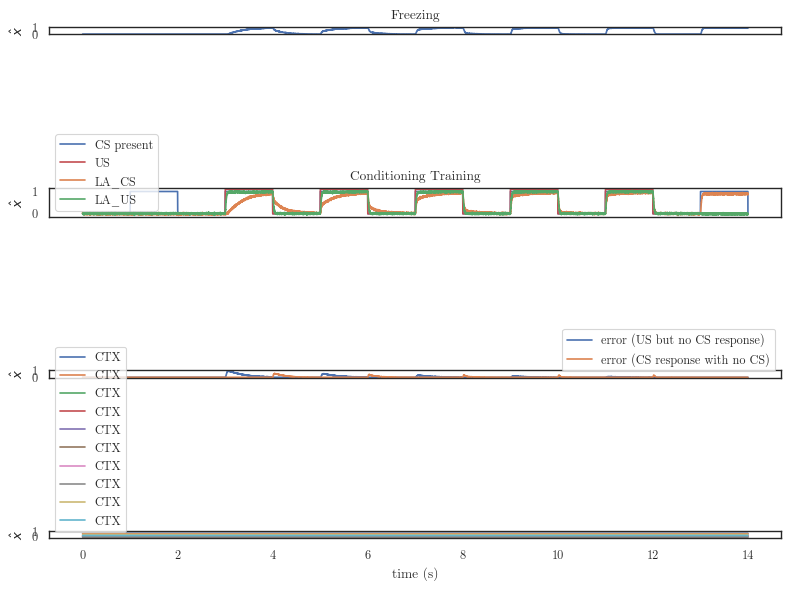

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,4,1]})
axes[0].plot(sim.trange(), sim.data[pCeA], label="CeA")
axes[0].set(yticks=((0, 1)), ylabel=r"$\hat{x}$", title="Freezing")
# axes[1].plot(sim.trange(), sim.data[pCS], label="CS")
axes[1].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), sim.data[pLA][:,0], label="LA_CS")
axes[1].plot(sim.trange(), sim.data[pLA][:,1], label="LA_US")
axes[1].legend()
axes[1].set(yticks=((0, 1)), ylabel=r"$\hat{x}$", title="Conditioning Training")
axes[2].plot(sim.trange(), sim.data[pError_CS], label="error (US but no CS response)")
axes[2].plot(sim.trange(), sim.data[pError_noCS], label="error (CS response with no CS)")
axes[2].legend()
axes[2].set(ylabel=r"$\hat{x}$", yticks=((0,1)))
plt.tight_layout()

In [6]:
A_baseline = sim.data[pLA_spikes][T_baseline_inactive: T_baseline_active]
A_expression = sim.data[pLA_spikes][T_expression_cond_inactive: T_expression_cond_active]
dA_cond = np.mean(A_expression - A_baseline, axis=0)
A_thr = 1.2  # neurons are "increasing" if they fire 20% more than baseline
increasing_neurons = np.where(np.mean(A_expression, axis=0) > A_thr*np.mean(A_baseline, axis=0))[0]
data_LA = pd.DataFrame(columns=["neuron", "Activity", "Experiment"])
for n in increasing_neurons:
    data_LA = data_LA.append({"neuron": n, "Activity": np.mean(A_baseline[:,n]), "Experiment": "baseline"}, ignore_index=True)
    data_LA = data_LA.append({"neuron": n, "Activity": np.mean(A_expression[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)

33.5% of LA neurons had >20% increased activity


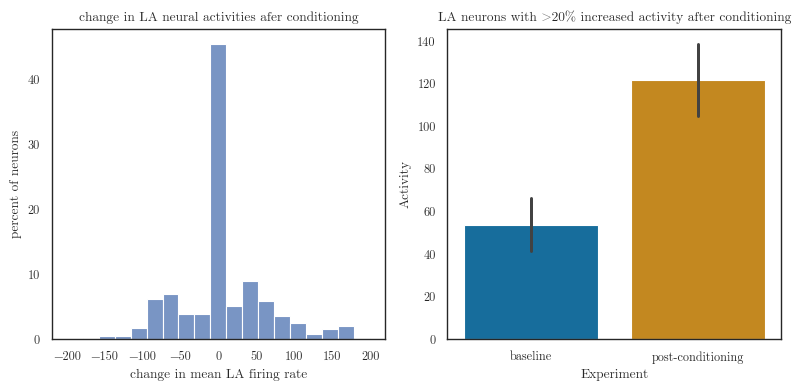

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((8,4)))
sns.histplot(dA_cond, ax=axes[0], bins=np.linspace(-200, 200, 20), stat='percent', palette=palette)
axes[0].set(xlabel='change in mean LA firing rate', ylabel='percent of neurons',
         title='change in LA neural activities afer conditioning')
sns.barplot(data=data_LA, x='Experiment', y="Activity", palette=palette)
axes[1].set(title="LA neurons with >20% increased activity after conditioning")
plt.tight_layout()
print(f"{len(increasing_neurons)/len(dA_cond)*100}% of LA neurons had >20% increased activity")

### Experiments 2: CS-CTX-US extinction

In [8]:
with net:
    # amygdala ensembles
    BLA = nengo.Ensemble(3*nNeurons, 4, radius=4)  # [CS, US, CTX, combined]
    # error ensembles
    error_CTX = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # feedforward connections
    nengo.Connection(LA, BLA[:2])  # transmit [CS, US] from LA to BLA
    # learned connections
    extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(1e-5))
    # CTX error connections
    nengo.Connection(BLA, error_CTX, function=lambda x: x[3]-x[1])  # (combined response) - US
    nengo.Connection(external_CS, error_CTX, function=lambda x: -1+np.sum(np.square(x)))  # CS must be present
    nengo.Connection(error_CTX, extinction.learning_rule, transform=1)
    # lateral/feedback connections
    nengo.Connection(BLA[0], BLA[3])  # CS response added to combined response
    nengo.Connection(BLA[2], BLA[3], transform=+1)  # CTX extinction response subtracted from combined response
    # output connections
    nengo.Connection(BLA[2], CeA)  # CTX response added to CeA state
    # probes
    pBLA_spikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pError_CTX = nengo.Probe(error_CTX)

In [9]:
dt = 0.001
nCond = 5
nExt = 10

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    T_baseline_inactive = int(1/dt)
    T_baseline_active = int(2/dt)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("post-conditioning expression")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    T_expression_cond_inactive = int((2+2*nCond+1)/dt)
    T_expression_cond_active = int((2+2*nCond+2)/dt)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    print("post-extinction expression")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    sim.run(2)
    T_expression_ext_inactive = int((2+2*nCond+2+2*nExt+1)/dt)
    T_expression_ext_active = int((2+2*nCond+2+2*nExt+2)/dt)
    print("renewal expression")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    T_expression_renewal_inactive = int((2+2*nCond+2+2*nExt+2+1)/dt)
    T_expression_renewal_active = int((2+2*nCond+2+2*nExt+2+2)/dt)

baseline
conditioning
post-conditioning expression
extinction
post-extinction expression
renewal expression


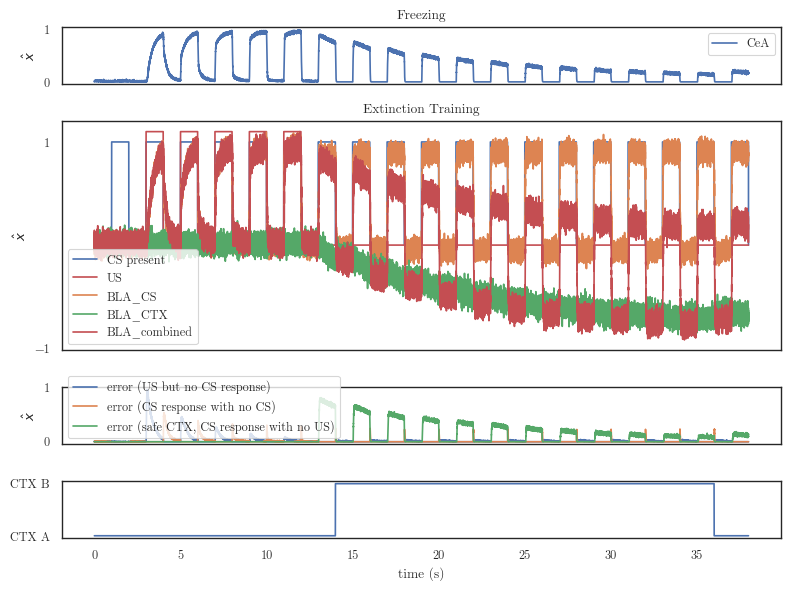

In [28]:
fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [1,4,1,1]})
axes[0].plot(sim.trange(), sim.data[pCeA], label="CeA")
# axes[0].plot(sim.trange(), sim.data[pLA][:,0] + sim.data[pBLA][:,2], label="diff")
axes[0].set(yticks=((0, 1)), ylabel=r"$\hat{x}$", title="Freezing")
axes[0].legend()
axes[1].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[1].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[1].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
# axes[1].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[1].plot(sim.trange(), sim.data[pBLA][:,2], label="BLA_CTX")
axes[1].plot(sim.trange(), sim.data[pBLA][:,3], label="BLA_combined")
axes[1].legend()
axes[1].set(yticks=((-1,1)), ylabel=r"$\hat{x}$", title="Extinction Training")
axes[2].plot(sim.trange(), sim.data[pError_CS], label="error (US but no CS response)")
axes[2].plot(sim.trange(), sim.data[pError_noCS], label="error (CS response with no CS)")
axes[2].plot(sim.trange(), sim.data[pError_CTX], label="error (safe CTX, CS response with no US)")
axes[2].legend()
axes[2].set(ylabel=r"$\hat{x}$")
ctxA_idx = np.where(sim.data[pCTX]==inputs.CTXs[0])[0]
ctxB_idx = np.where(sim.data[pCTX]==inputs.CTXs[1])[0]
ctx_signal = np.zeros((sim.trange().shape[0]))
ctx_signal[ctxB_idx] = 1
axes[3].plot(sim.trange(), ctx_signal, label="CTX")
axes[3].set(xlabel="time (s)", yticks=((0,1)), yticklabels=(("CTX A", "CTX B")))
plt.tight_layout()

In [11]:
A_baseline = sim.data[pBLA_spikes][T_baseline_inactive: T_baseline_active]
A_expression = sim.data[pBLA_spikes][T_expression_cond_inactive: T_expression_cond_active]
dA_cond = np.mean(A_expression - A_baseline, axis=0)
A_thr = 1.2  # neurons are "increasing" if they fire 20% more than baseline
increasing_neurons = np.where(np.mean(A_expression, axis=0) > A_thr*np.mean(A_baseline, axis=0))[0]
data_BLA = pd.DataFrame(columns=["neuron", "Activity", "Experiment"])
for n in increasing_neurons:
    data_BLA = data_BLA.append({"neuron": n, "Activity": np.mean(A_baseline[:,n]), "Experiment": "baseline"}, ignore_index=True)
    data_BLA = data_BLA.append({"neuron": n, "Activity": np.mean(A_expression[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)

13.5% of BLA neurons had >20% increased activity


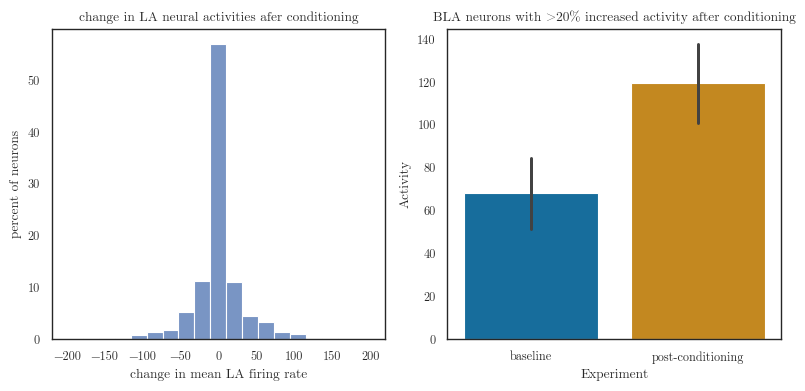

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((8,4)))
sns.histplot(dA_cond, ax=axes[0], bins=np.linspace(-200, 200, 20), stat='percent', palette=palette)
axes[0].set(xlabel='change in mean LA firing rate', ylabel='percent of neurons',
         title='change in LA neural activities afer conditioning')
sns.barplot(data=data_BLA, x='Experiment', y="Activity", palette=palette)
axes[1].set(title="BLA neurons with >20% increased activity after conditioning")
plt.tight_layout()
print(f"{len(increasing_neurons)/len(dA_cond)*100}% of BLA neurons had >20% increased activity")

In [13]:
A_post_cond = sim.data[pBLA_spikes][T_expression_cond_inactive: T_expression_cond_active]
A_post_ext = sim.data[pBLA_spikes][T_expression_ext_inactive: T_expression_ext_active]
dA_ext = np.mean(A_post_ext - A_post_cond, axis=0)
A_thr_pos = 1.2  # neurons are "increasing" if they fire >20% more than the post-conditioning baseline
A_thr_neg = 0.8  # neurons are "decreasing" if they fire at <80% of post-conditioning baseline
extinction_neurons = np.where(np.mean(A_post_ext, axis=0) > A_thr_pos*np.mean(A_post_cond, axis=0))[0]
fear_neurons = np.where(np.mean(A_post_ext, axis=0) < A_thr_neg*np.mean(A_post_cond, axis=0))[0]
all_neurons = np.arange(dA_ext.shape[0])
nonpersistent_neurons = np.concatenate((extinction_neurons, fear_neurons))
persistent_neurons = np.setdiff1d(all_neurons, nonpersistent_neurons)
print(f"{len(fear_neurons)/len(dA_ext)*100:.3}% of BLA neurons are 'fear neurons'")
print(f"{len(extinction_neurons)/len(dA_ext)*100:.3}% of BLA neurons are 'extinction neurons'")
print(f"{len(persistent_neurons)/len(dA_ext)*100:.3}% of BLA neurons are 'persistent neurons'")

data_BLA_types = pd.DataFrame(columns=["neuron", "type", "Activity", "Experiment"])
for n in fear_neurons:
    data_BLA_types = data_BLA_types.append({"neuron": n, "type": "fear", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)
    data_BLA_types = data_BLA_types.append({"neuron": n, "type": "fear", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "post-extinction"}, ignore_index=True)
for n in persistent_neurons:
    data_BLA_types = data_BLA_types.append({"neuron": n, "type": "persistent", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)
    data_BLA_types = data_BLA_types.append({"neuron": n, "type": "persistent", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "post-extinction"}, ignore_index=True)
for n in extinction_neurons:
    data_BLA_types = data_BLA_types.append({"neuron": n, "type": "extinction", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)
    data_BLA_types = data_BLA_types.append({"neuron": n, "type": "extinction", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "post-extinction"}, ignore_index=True)

9.0% of BLA neurons are 'fear neurons'
13.2% of BLA neurons are 'extinction neurons'
77.8% of BLA neurons are 'persistent neurons'


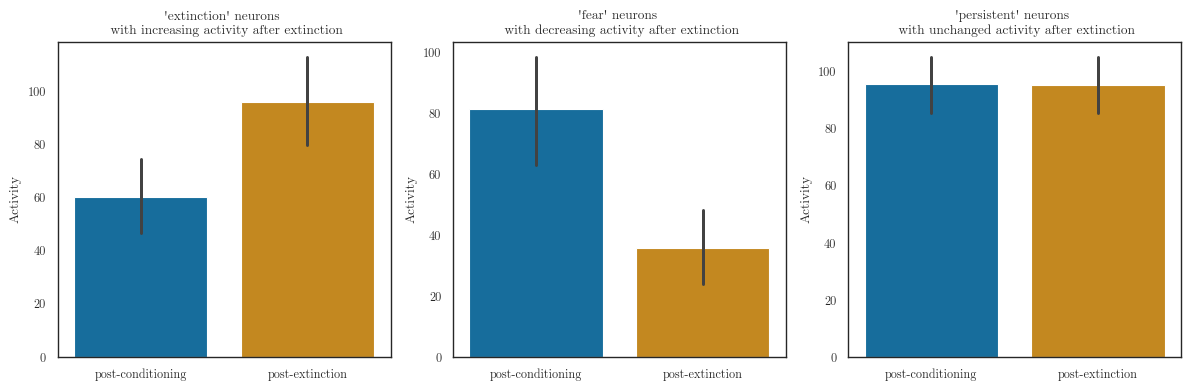

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((12,4)))
sns.barplot(data=data_BLA_types.query("type=='extinction'"), x='Experiment', y="Activity", palette=palette, ax=axes[0])
axes[0].set(title="'extinction' neurons \n with increasing activity after extinction", xlabel=None)
sns.barplot(data=data_BLA_types.query("type=='fear'"), x='Experiment', y="Activity", palette=palette, ax=axes[1])
axes[1].set(title="'fear' neurons \n with decreasing activity after extinction", xlabel=None)
sns.barplot(data=data_BLA_types.query("type=='persistent'"), x='Experiment', y="Activity", palette=palette, ax=axes[2])
axes[2].set(title="'persistent' neurons \n with unchanged activity after extinction", xlabel=None)
plt.tight_layout()

In [15]:
# data_fear = pd.DataFrame(columns=["Time", "Freezing", "Experiment"])
# experiment = "baseline (inactive)"
# for t in sim.trange():
#     if t>=1: experiment = "baseline"
#     if t>=2: experiment = "conditioning"
#     if t>=2+2*nCond: experiment = "post-conditioning expression (inactive)"
#     if t>=2+2*nCond+1: experiment = "post-conditioning expression"
#     if t>=2+2*nCond+2: experiment = "expression"
#     if t>=2+2*nCond+2+2*nExt: experiment = "post-extinction expression (inactive)"
#     if t>=2+2*nCond+2+2*nExt+1: experiment = "post-extinction expression"
#     if t>=2+2*nCond+2+2*nExt+2: experiment = "renewal expression (inactive)"
#     if t>=2+2*nCond+2+2*nExt+2+1: experiment = "renewal expression"
#     data_fear = data_fear.append({"Time": t, "Freezing": sim.data[pCeA][int((t-dt)/dt)][0], "Experiment": experiment}, ignore_index=True)

# print(data_fear)
# fig, ax = plt.subplots(figsize=((8,8)))
# sns.histplot(data=data_fear, x='Experiment', y="Freezing")

In [16]:
data_fear = pd.DataFrame(columns=["Freezing", "Experiment"])
data_fear = data_fear.append({
    "Freezing": np.mean(sim.data[pCeA][T_baseline_inactive: T_baseline_active]),
    "Experiment": "baseline"},
    ignore_index=True)
data_fear = data_fear.append({
    "Freezing": np.mean(sim.data[pCeA][T_expression_cond_inactive: T_expression_cond_active]),
    "Experiment": 'conditioning'},
    ignore_index=True)
data_fear = data_fear.append({
    "Freezing": np.mean(sim.data[pCeA][T_expression_ext_inactive: T_expression_ext_active]),
    "Experiment": 'extinction'},
    ignore_index=True)
data_fear = data_fear.append({
    "Freezing": np.mean(sim.data[pCeA][T_expression_renewal_inactive: T_expression_renewal_active]),
    "Experiment": 'renewal'},
    ignore_index=True)

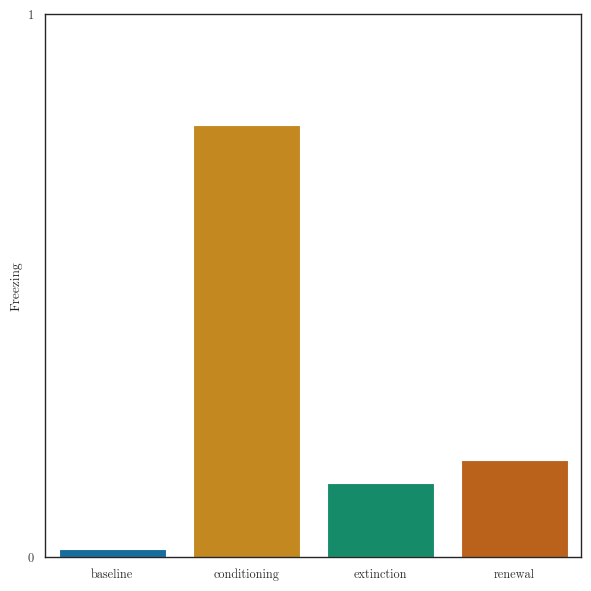

In [17]:
fig, ax = plt.subplots(figsize=((6,6)))
sns.barplot(data=data_fear, x='Experiment', y="Freezing", palette=palette[:4])
ax.set(xlabel=None, yticks=((0,1)))
plt.tight_layout()

In [18]:
inputs.CTXs[0]

array([ 0.61482987,  0.51239856, -0.26813399,  0.26067407, -0.04152761,
       -0.02831997,  0.11265518,  0.03952098,  0.39900643,  0.20880456])

In [19]:
inputs.CTXs[1]

array([ 0.03649245,  0.13312229,  0.10007472,  0.44810025, -0.06153052,
        0.09389444, -0.25615814, -0.76568596,  0.19603156,  0.25925942])

In [20]:
np.dot(inputs.CTXs[0], inputs.CTXs[1])

0.2537533289437394